# Prelims

In [2]:
import pandas as pd
# visuals
import matplotlib.pyplot as plt
import seaborn as sns
# learning
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
#from sklearn_extra.cluster import KMedoids
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import prince
# metrics.cluster.contingency_matrix
from sklearn import metrics
from sklearn.metrics import calinski_harabasz_score
# Numpy
import numpy as np
from scipy.special import comb

import gower

In [3]:
df = pd.read_csv('./in-vehicle-coupon-recommendation.csv')

In [4]:
df = df.drop(columns=['car'])
df = df.drop(columns=['toCoupon_GEQ5min'])
df = df.drop(columns=['direction_opp'])
df = df.drop_duplicates()

In [5]:
for column in df.columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [6]:
def value_mapping(df: pd.DataFrame):
    frequency_map = {'never': 0,'less1': 1,'1~3': 2,'4~8': 3,'gt8': 4}
    age_map = {'below21': 0,'21': 1,'26': 2,'31': 3,'36': 4,'41': 5,'46': 6,'50plus': 7}
    income_map = {'Less than $12500': 0,'$12500 - $24999': 1,'$25000 - $37499': 2,'$37500 - $49999': 3,
    '$50000 - $62499': 4,'$62500 - $74999': 5,'$75000 - $87499': 6,'$87500 - $99999': 7,'$100000 or More': 8}
    temperature_map = {30: 0,55: 1,80: 2}

    # CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50, Bar
    df['CoffeeHouse'] = df['CoffeeHouse'].map(frequency_map)
    df['CarryAway'] = df['CarryAway'].map(frequency_map)
    df['RestaurantLessThan20'] = df['RestaurantLessThan20'].map(frequency_map)
    df['Restaurant20To50'] = df['Restaurant20To50'].map(frequency_map)
    df['Bar'] = df['Bar'].map(frequency_map)

    #age
    df['age'] = df['age'].map(age_map)

    #income 
    df['income'] = df['income'].map(income_map)

    #temperature
    df['temperature'] = df['temperature'].map(temperature_map)

    return df

In [7]:
df = value_mapping(df)

In [8]:
df['Y']

0        1
1        0
2        1
3        0
4        0
        ..
12679    1
12680    1
12681    0
12682    0
12683    0
Name: Y, Length: 12610, dtype: int64

In [9]:
from sklearn.preprocessing import OrdinalEncoder

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Columns for ordinal encoding
ordinal_cols = ['destination', 'weather', 'time', 'expiration', 'maritalStatus', 'education']

# Define the specific ordering for ordinal columns
ordinal_ordering = {
    'destination': ['No Urgent Place', 'Home', 'Work'],
    'weather': ['Sunny', 'Rainy', 'Snowy'],
    'time': ['7AM', '10AM', '2PM', '6PM', '10PM'],
    'expiration': ['2h', '1d'],
    'maritalStatus': ['Single', 'Unmarried partner', 'Married partner', 'Divorced', 'Widowed'],
    'education': ['Some High School', 'High School Graduate', 'Some college - no degree', 
                  'Associates degree', 'Bachelors degree', 'Graduate degree (Masters or Doctorate)']
}

# Ordinal encoding
ordinal_encoder = OrdinalEncoder(categories=[ordinal_ordering[col] for col in ordinal_cols])
df[ordinal_cols] = ordinal_encoder.fit_transform(df[ordinal_cols])

# Identify columns to be one-hot encoded (excluding already binary or ordinal encoded columns)
columns_to_encode = df.columns.drop(ordinal_cols + ['temperature', 'age', 'has_children', 'income',
                                                    'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20',
                                                    'Restaurant20To50', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 
                                                    'direction_same', 'Y'])  # Add any other columns to exclude

# One-hot encoding for the non-binary categorical columns
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=False, dtype=int)

# df now contains your processed data


In [10]:
X = df.drop("Y", axis=1)
y = df["Y"]

### MCA

In [11]:
# Define the number of components you want to analyze
n_components = 20  # Adjust this number as needed
mca = prince.MCA(
    n_components=n_components,
    check_input=True,
    random_state=42
) #prince.MCA(n_components=n_components, random_state=42, one_hot=False)
X_mca = mca.fit_transform(X)



print(mca.eigenvalues_summary)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.067         3.82%                      3.82%
1              0.056         3.18%                      7.00%
2              0.046         2.63%                      9.63%
3              0.043         2.44%                     12.07%
4              0.042         2.39%                     14.46%
5              0.038         2.16%                     16.62%
6              0.037         2.11%                     18.73%
7              0.034         1.95%                     20.68%
8              0.033         1.86%                     22.54%
9              0.032         1.80%                     24.34%
10             0.031         1.74%                     26.09%
11             0.030         1.70%                     27.78%
12             0.029         1.66%                     29.44%
13             0.028         1.59%                     31.03%
14      

### PCA

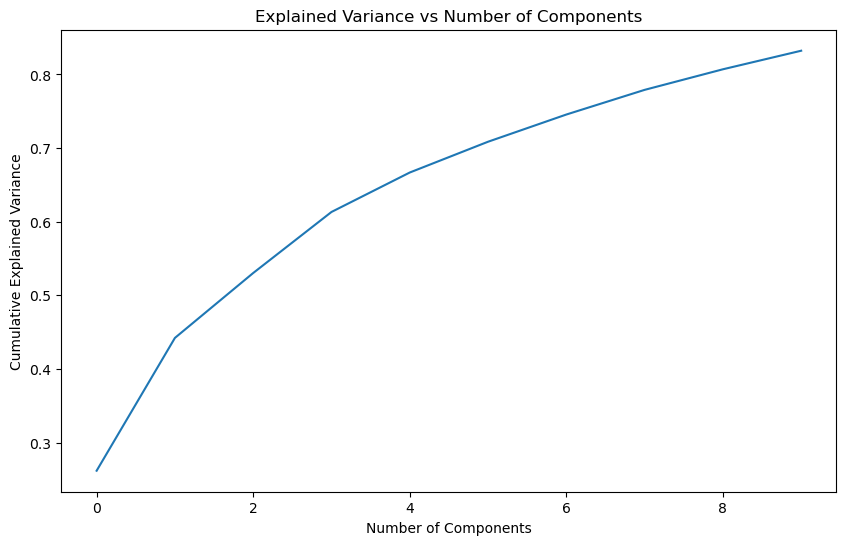

If all 10 components are used, then the cumulative explained variance ratio is 83.22562657340296%


In [82]:
# PCA instead of MCA
n_components = 10 # Adjust this number as needed , 2 yielded not daunting results
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X)

# plotting the cumulative sum of the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs Number of Components")
plt.show()

# how much cumulative in total if all are used?
print("If all " + str(X_pca.shape[-1]) + " components are used, then the cumulative explained variance ratio is " + str(np.cumsum(pca.explained_variance_ratio_)[-1]*100) + "%")

# changing X_pca to a dataframe
X_pca = pd.DataFrame(X_pca)

In [13]:
for column in X.columns:
    print(f"{column}: {X[column].unique()}")

destination: [0. 1. 2.]
weather: [0. 1. 2.]
temperature: [1 2 0]
time: [2. 1. 3. 0. 4.]
expiration: [1. 0.]
age: [1 6 2 3 5 7 4 0]
maritalStatus: [1. 0. 2. 3. 4.]
has_children: [1 0]
education: [2. 4. 3. 1. 5. 0.]
income: [3 5 1 6 4 2 8 7 0]
Bar: [0 1 2 4 3]
CoffeeHouse: [0 1 3 2 4]
CarryAway: [2 3 4 1 0]
RestaurantLessThan20: [3 2 1 4 0]
Restaurant20To50: [2 1 0 4 3]
toCoupon_GEQ15min: [0 1]
toCoupon_GEQ25min: [0 1]
direction_same: [0 1]
passanger_Alone: [1 0]
passanger_Friend(s): [0 1]
passanger_Kid(s): [0 1]
passanger_Partner: [0 1]
coupon_Bar: [0 1]
coupon_Carry out & Take away: [0 1]
coupon_Coffee House: [0 1]
coupon_Restaurant(20-50): [0 1]
coupon_Restaurant(<20): [1 0]
gender_Female: [1 0]
gender_Male: [0 1]
occupation_Architecture & Engineering: [0 1]
occupation_Arts Design Entertainment Sports & Media: [0 1]
occupation_Building & Grounds Cleaning & Maintenance: [0 1]
occupation_Business & Financial: [0 1]
occupation_Community & Social Services: [0 1]
occupation_Computer & Math

# Clustering 

### Cluster Quality Analysis functions

In [14]:
# Calculate purity
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

# Indice Rand
# import comb


def rand_index_score(clusters, classes):
    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

# F-measure
def f_measure(y_true, y_pred):
    # Compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)

    # Compute precision and recall
    row_sums = contingency_matrix.sum(axis=1)
    col_sums = contingency_matrix.sum(axis=0)

    # Ensure proper broadcasting by reshaping row_sums
    precision = np.max(contingency_matrix / col_sums, axis=0).mean()
    recall = np.max(contingency_matrix / row_sums[:, np.newaxis], axis=1).mean()

    # Compute f measure
    return 2 * precision * recall / (precision + recall)


### Hierarchical Clustering

Metrics for Single Linkage with 2 clusters:
Contingency Matrix:
[[   8 5445]
 [  12 7145]]
Number of Clusters: 2
Samples per Cluster: [   20 12590]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5090057081315167
F-Measure: 0.7367524379809234



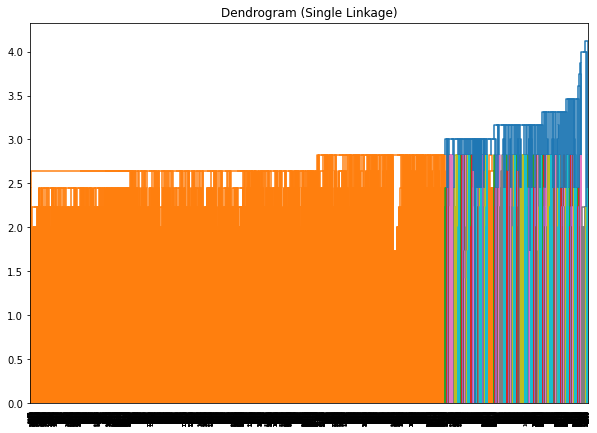

Metrics for Single Linkage with 3 clusters:
Contingency Matrix:
[[   8 5445]
 [  12 7145]]
Number of Clusters: 2
Samples per Cluster: [   20 12590]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5090057081315167
F-Measure: 0.7367524379809234



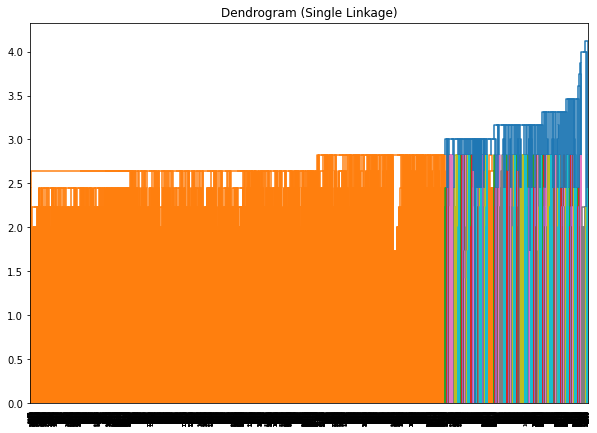

Metrics for Single Linkage with 4 clusters:
Contingency Matrix:
[[   8    7   45 5393]
 [  12   15   64 7066]]
Number of Clusters: 4
Samples per Cluster: [   20    22   109 12459]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5084356056739553
F-Measure: 0.7535907660672423



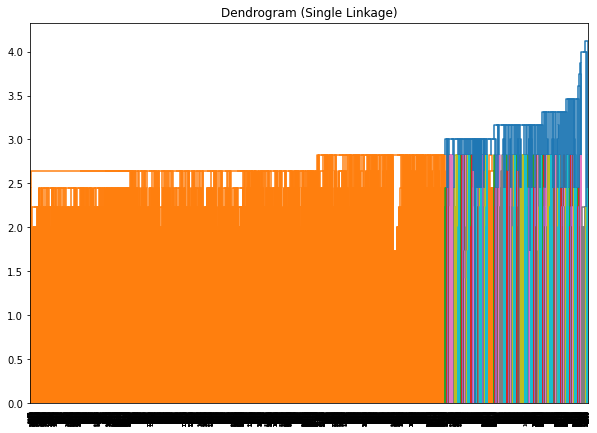

Metrics for Complete Linkage with 2 clusters:
Contingency Matrix:
[[2986 2467]
 [4236 2921]]
Number of Clusters: 2
Samples per Cluster: [7222 5388]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5019528553204793
F-Measure: 0.567019272157278



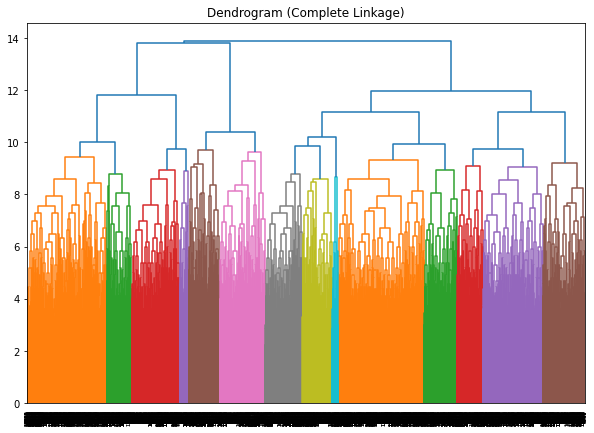

Metrics for Complete Linkage with 3 clusters:
Contingency Matrix:
[[2986  747 1720]
 [4236  985 1936]]
Number of Clusters: 3
Samples per Cluster: [7222 1732 3656]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5013062117369056
F-Measure: 0.5656329687473837



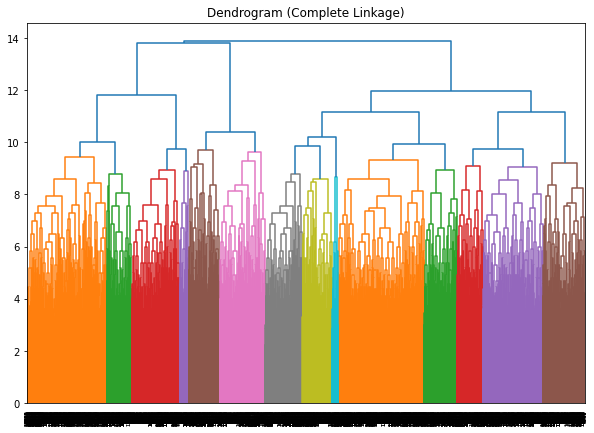

Metrics for Complete Linkage with 4 clusters:
Contingency Matrix:
[[1233 1753  747 1720]
 [1653 2583  985 1936]]
Number of Clusters: 4
Samples per Cluster: [2886 4336 1732 3656]
Purity Score: 0.5675654242664552
Rand Index Score: 0.4969212920116914
F-Measure: 0.42593234952553266



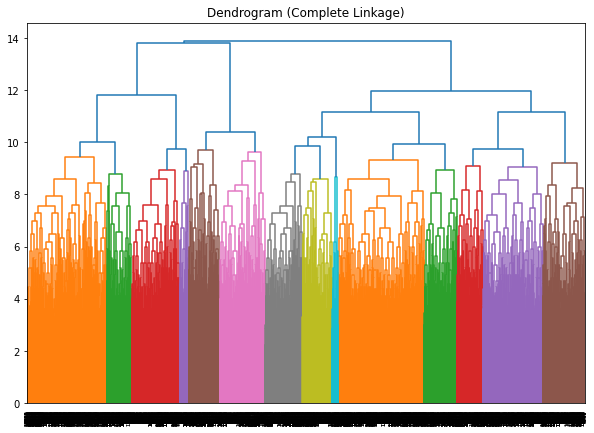

Metrics for Average Linkage with 2 clusters:
Contingency Matrix:
[[  52 5401]
 [  79 7078]]
Number of Clusters: 2
Samples per Cluster: [  131 12479]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5085216940004021
F-Measure: 0.7354466362521461



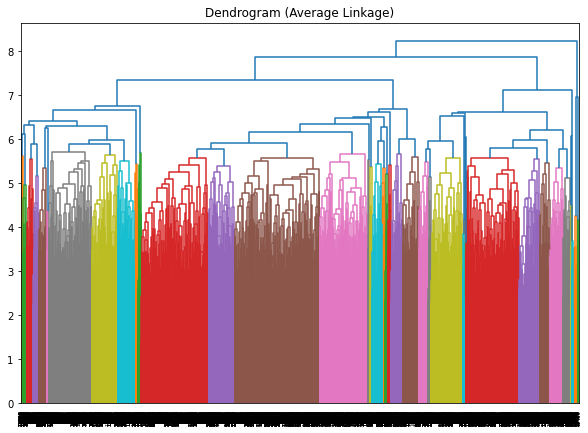

Metrics for Average Linkage with 3 clusters:
Contingency Matrix:
[[  52 1586 3815]
 [  79 1891 5187]]
Number of Clusters: 3
Samples per Cluster: [ 131 3477 9002]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5032580293182073
F-Measure: 0.6358958663107773



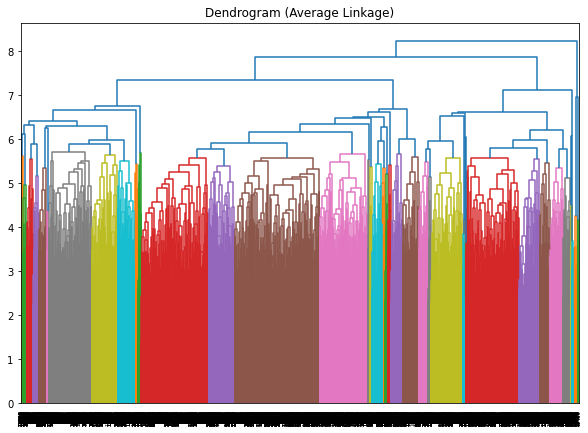

Metrics for Average Linkage with 4 clusters:
Contingency Matrix:
[[  52 1586 2603 1212]
 [  79 1891 3669 1518]]
Number of Clusters: 4
Samples per Cluster: [ 131 3477 6272 2730]
Purity Score: 0.5675654242664552
Rand Index Score: 0.49915492181767374
F-Measure: 0.5307140708386033



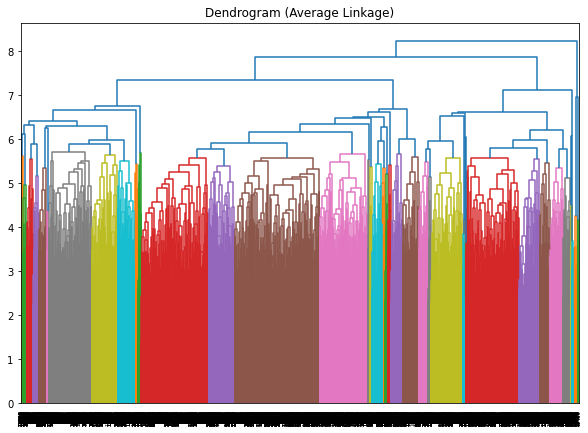

Metrics for Ward Linkage with 2 clusters:
Contingency Matrix:
[[1630 3823]
 [1977 5180]]
Number of Clusters: 2
Samples per Cluster: [3607 9003]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5031682177093776
F-Measure: 0.6281673634399656



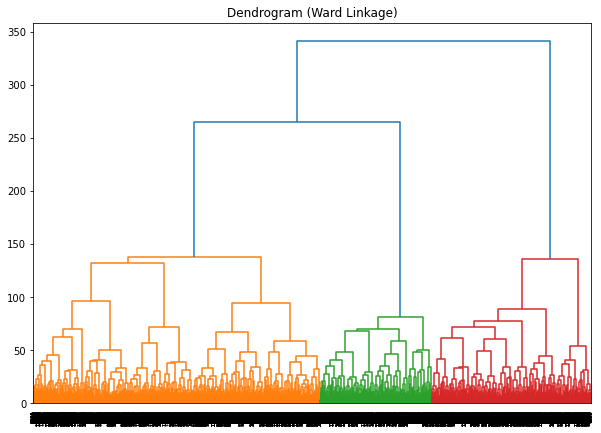

Metrics for Ward Linkage with 3 clusters:
Contingency Matrix:
[[1630 1150 2673]
 [1977 1365 3815]]
Number of Clusters: 3
Samples per Cluster: [3607 2515 6488]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5000797801301123
F-Measure: 0.5345417740084304



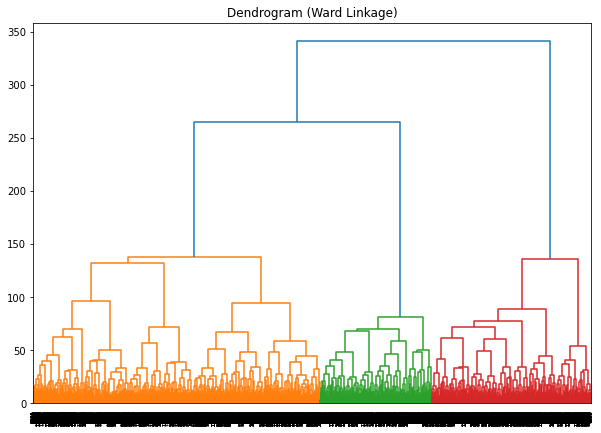

Metrics for Ward Linkage with 4 clusters:
Contingency Matrix:
[[1630 1150 1111 1562]
 [1977 1365 1784 2031]]
Number of Clusters: 4
Samples per Cluster: [3607 2515 2895 3593]
Purity Score: 0.5675654242664552
Rand Index Score: 0.4961094906656619
F-Measure: 0.38516227053594765



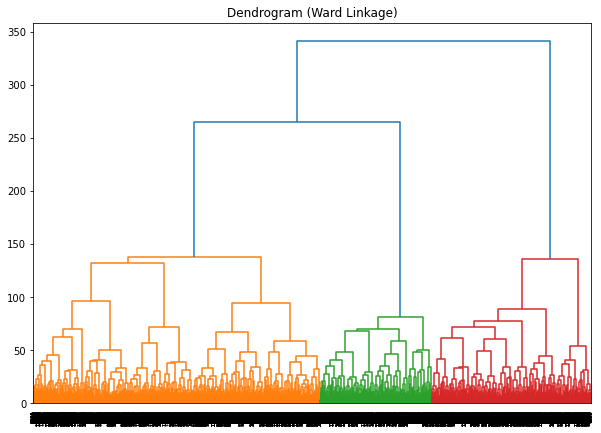

Metrics for Centroid Linkage with 2 clusters:
Contingency Matrix:
[[   3 5450]
 [  15 7142]]
Number of Clusters: 2
Samples per Cluster: [   18 12592]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5088358459514556
F-Measure: 0.8232597406324964



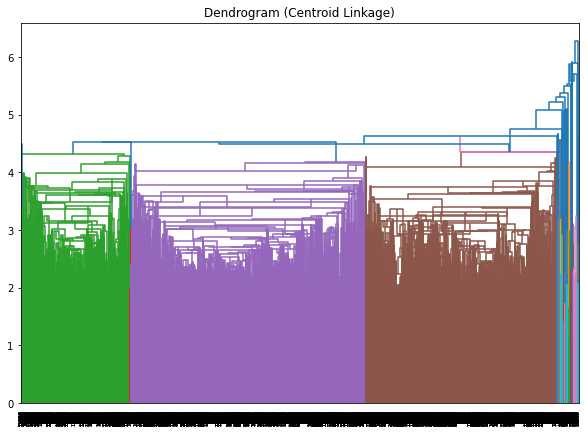

Metrics for Centroid Linkage with 3 clusters:
Contingency Matrix:
[[   3 5450]
 [  15 7142]]
Number of Clusters: 2
Samples per Cluster: [   18 12592]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5088358459514556
F-Measure: 0.8232597406324964



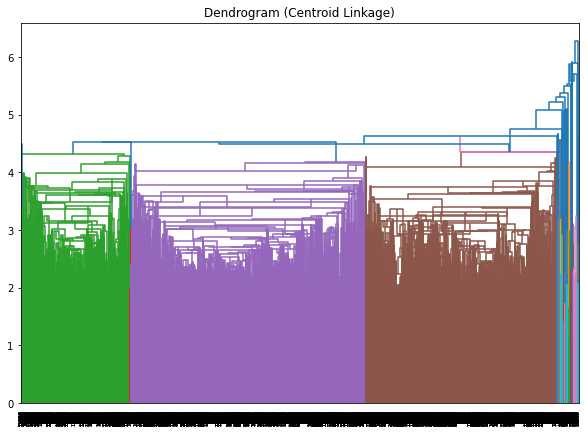

Metrics for Centroid Linkage with 4 clusters:
Contingency Matrix:
[[   3 5450]
 [  15 7142]]
Number of Clusters: 2
Samples per Cluster: [   18 12592]
Purity Score: 0.5675654242664552
Rand Index Score: 0.5088358459514556
F-Measure: 0.8232597406324964



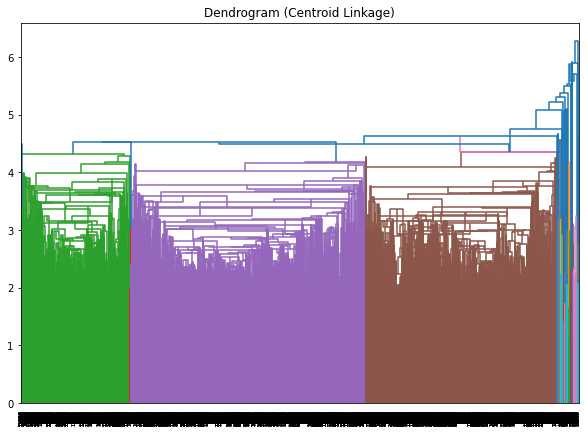

In [27]:
linkage_methods = ['single', 'complete', 'average', 'ward', 'centroid']
n_clusters_range = range(2, 5)  # Example: considering 2 to 4 clusters

for method in linkage_methods:
    # Perform hierarchical clustering
    linked = linkage(X, method=method)
    
    for n_clusters in n_clusters_range:
        # Obtain cluster labels
        y_pred = fcluster(linked, n_clusters, criterion='maxclust') 

        # Print contingency matrix and other metrics
        print(f"Metrics for {method.capitalize()} Linkage with {n_clusters} clusters:")
        print(f"Contingency Matrix:\n{metrics.cluster.contingency_matrix(y, y_pred)}")
        print(f"Number of Clusters: {np.unique(y_pred).size}")
        print(f"Samples per Cluster: {np.unique(y_pred, return_counts=True)[1]}")
        print(f"Purity Score: {purity_score(y, y_pred)}")
        print(f"Rand Index Score: {rand_index_score(y, y_pred)}")
        print(f"F-Measure: {f_measure(y, y_pred)}\n")

        # Plot the dendrogram
        plt.figure(figsize=(10, 7))
        dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
        plt.title(f"Dendrogram ({method.capitalize()} Linkage)")
        plt.show()
    

Métricas Externas
Pureza:

Avalia até que ponto cada cluster contém objetos de uma única classe.
Valores mais altos indicam melhor performance.
Índice Rand:

Mede a porcentagem de decisões corretas (isto é, pares de objetos no mesmo ou em diferentes clusters).
Valores mais altos indicam melhor performance.
F-Measure:

Combina precisão e recall para avaliar a qualidade do clustering.
Valores mais altos indicam melhor performance.

### K-medoids

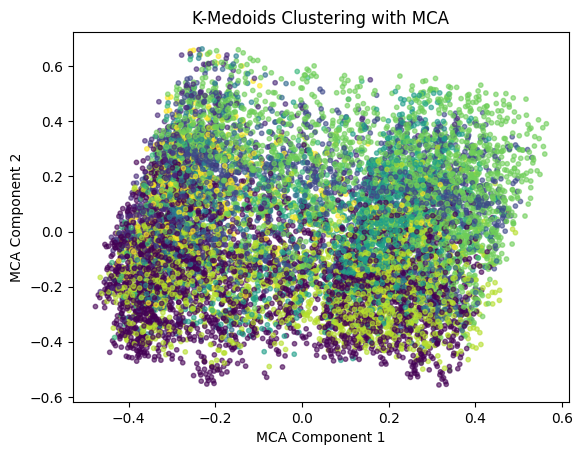

In [86]:
# K-Medoids clustering
kmedoids = KMedoids(n_clusters=10, random_state=0)
clusters = kmedoids.fit_predict(X)
                                
plt.scatter(X_mca[0], X_mca[1], c=clusters, cmap='viridis', alpha=0.6, s=10)
plt.title("K-Medoids Clustering with MCA")
plt.xlabel("MCA Component 1")
plt.ylabel("MCA Component 2")
plt.show()

In [87]:
df_test1 = df.copy()

In [88]:
df_test1['Cluster_Kmedoids'] = clusters

In [89]:
# Group by cluster label and then count the occurrences of each class in each cluster
class_distribution = df_test1.groupby('Cluster_Kmedoids')['Y'].value_counts()

print(class_distribution)

Cluster_Kmedoids  Y
0                 1    1527
                  0    1328
1                 1     433
                  0     312
2                 1     784
                  0     553
3                 1     283
                  0     138
4                 1     276
                  0     113
5                 1     463
                  0     426
6                 1     470
                  0     259
7                 1    1452
                  0    1057
8                 1    1188
                  0    1070
9                 1     281
                  0     197
Name: count, dtype: int64


In [14]:
# Range of k to evaluate
k_range = range(2, 10)  # Adjust according to your needs

# Store CH scores for each k
ch_scores = []

for k in k_range:
    # Apply K-Medoids
    kmedoids = KMedoids(n_clusters=k, random_state=0)
    clusters = kmedoids.fit_predict(X)
    
    # Calculate CH index
    ch_score = calinski_harabasz_score(X, clusters)
    ch_scores.append(ch_score)
    print(f"CH Score for k={k}: {ch_score}")

# Find the k with the highest CH score
best_k = k_range[ch_scores.index(max(ch_scores))]
print(f"Best number of clusters by CH index: {best_k}")

CH Score for k=2: 1810.1795221433588
CH Score for k=3: 993.4609532969721
CH Score for k=4: 681.2243821969652
CH Score for k=5: 525.252019306173
CH Score for k=6: 468.5927961372095
CH Score for k=7: 645.8646174028906
CH Score for k=8: 862.6776493125182
CH Score for k=9: 874.9098368676857
Best number of clusters by CH index: 2


### K-modes

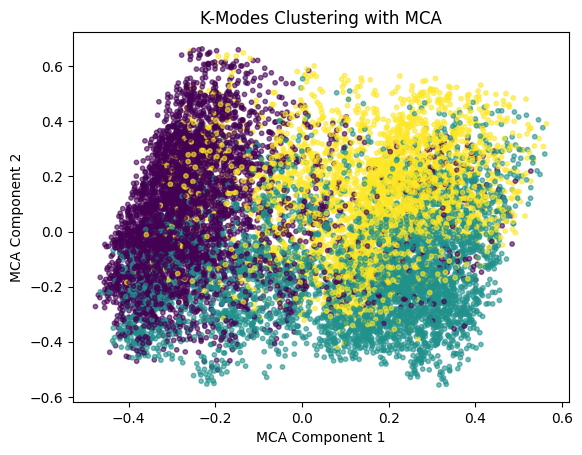

In [90]:
# K-Modes clustering
km = KModes(n_clusters=3, init='Huang', n_init=5, random_state=0)
clusters = km.fit_predict(X)

plt.scatter(X_mca[0], X_mca[1], c=clusters, cmap='viridis', alpha=0.6, s = 10)
plt.title("K-Modes Clustering with MCA")
plt.xlabel("MCA Component 1")
plt.ylabel("MCA Component 2")
plt.show()

In [92]:
df_test2 = df.copy()

df_test2['Cluster_Kmodes'] = clusters

# Group by cluster label and then count the occurrences of each class in each cluster
class_distribution = df_test2.groupby('Cluster_Kmodes')['Y'].value_counts()

print(class_distribution)

Cluster_Kmodes  Y
0               1    2795
                0    1562
1               1    2427
                0    2337
2               1    1935
                0    1554
Name: count, dtype: int64


In [12]:
from sklearn.metrics import calinski_harabasz_score

# Range of k to evaluate
k_range = range(2, 10)  # Adjust according to your needs

# Store CH scores for each k
ch_scores = []

for k in k_range:
    # Apply K-Modes
    km = KModes(n_clusters=k, init='Huang', random_state=42)
    clusters = km.fit_predict(X)
    
    # Calculate CH index
    ch_score = calinski_harabasz_score(X, clusters)
    ch_scores.append(ch_score)
    print(f"CH Score for k={k}: {ch_score}")

# Find the k with the highest CH score
best_k = k_range[ch_scores.index(max(ch_scores))]
print(f"Best number of clusters by CH index: {best_k}")

CH Score for k=2: 501.94758520922886
CH Score for k=3: 303.8719391630173
CH Score for k=4: 276.52770229937215
CH Score for k=5: 294.5535981928757
CH Score for k=6: 214.18987980628108
CH Score for k=7: 233.52608631937755
CH Score for k=8: 220.7497618945498
CH Score for k=9: 175.45447782011559
Best number of clusters by CH index: 2


### DBSCAN

In [49]:
def plot_sorted_distances(sorted_distances):
    # computing eps heuristic
    mean_distance = sorted_distances.mean()
    std_distance = sorted_distances.std()
    eps_heuristic = mean_distance + 2 * std_distance
    # plotting
    plt.figure(figsize=(12,6))
    plt.plot(sorted_distances)
    # adding eps heuristic line
    plt.axhline(y=eps_heuristic, color='r', linestyle='--')
    plt.title("k-Distance Graph")
    plt.xlabel("Points sorted by distance to the k-th nearest neighbor")
    plt.ylabel("k-th nearest neighbor distance")
    plt.grid(True)
    plt.show()

def plot_results(X_used, clusters, with_noise_Q=False):
    
    plt.figure(figsize=(12, 6))
    plt.scatter(X_used.iloc[:, 0], X_used.iloc[:, 1], c=clusters, cmap='viridis', alpha=0.6, marker='o')
    
    if with_noise_Q:
        plt.scatter(X_used.iloc[clusters == -1, 0], X_used.iloc[clusters == -1, 1], c='red', alpha=1, marker='x')

    plt.title("DBSCAN Clustering")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.colorbar()
    plt.show()

def print_results(clusters):
    print("\n")
    # checking results DBSCAN results with purity score
    print(f"Purity Score: {purity_score(y, clusters)}")
    # with f-measure
    print(f"F-Measure: {f_measure(y, clusters)}")
    # percentage of outliers
    print(f"Percentage of outliers: {np.count_nonzero(clusters == -1) / len(clusters) * 100}%, i.e. {np.count_nonzero(clusters == -1)} out of {len(clusters)}")
    # cluster's sizes
    print(f"Clusters' sizes: {np.unique(clusters, return_counts=True)[1]}")


def get_DBSCAN(X, X_mca, gower_matrix, k, eps, distance_metric, with_noise_Q=False, plotsQ=False, resultsQ=False, clustersQ=False):

    # Step 0: Calculate Gower Distance Matrix (if distance_metric='gower')
    if distance_metric == 'gower':
        d_metric = 'precomputed'
    else:
        d_metric = distance_metric

    # Applying DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=k, metric=d_metric)
    if distance_metric == 'gower':
        clusters = dbscan.fit_predict(gower_matrix)
    else:
        clusters = dbscan.fit_predict(X)
    

    # Enhanced Visualization
    if plotsQ:
        X_used = X_mca
        plot_results(X_used, clusters, with_noise_Q)

    # Step 4: Post-Clustering Analysis
    if resultsQ:
        print_results(clusters)

    if clustersQ:
       return clusters
    
def get_k_dist_plot(X, gower_matrix, k, distance_metric, eps_heuristicQ = False, plotQ = True):
    # Step 0: Calculate Gower Distance Matrix (if distance_metric='gower') cov = np.cov(X, rowvar=False)
    if distance_metric == 'gower':
        d_metric = 'precomputed'
    else:
        d_metric = distance_metric

    # Step 1: Calculate k-distances
    neigh = NearestNeighbors(n_neighbors=k, metric=d_metric)
    if distance_metric == 'gower':
        neigh.fit(gower_matrix)
        distances, indices = neigh.kneighbors(gower_matrix)
    else:
        neigh.fit(X)
        distances, indices = neigh.kneighbors(X)
    

    # Step 2: Sort k-distances and plot
    sorted_distances = np.sort(distances, axis=0)[:, k-1]
    if plotQ:
        plot_sorted_distances(sorted_distances)

    # Step 3: eps heuristic, if wanted
    if eps_heuristicQ:
        mean_distance = sorted_distances.mean()
        std_distance = sorted_distances.std()
        eps_heuristic = mean_distance + 2 * std_distance
        return eps_heuristic


def plot_cluster_class_distribution(clusters, y, points_for_show, var_heightQ=True):
    # Creating a DataFrame with cluster and class labels
    df = pd.DataFrame({'Cluster': clusters, 'Class': y})

    # Calculate the absolute counts of classes within each cluster
    cluster_class_distribution = df.groupby(['Cluster', 'Class']).size().unstack().fillna(0)

    # Filter clusters based on the minimum number of points
    clusters_to_show = cluster_class_distribution.sum(axis=1) >= points_for_show
    filtered_cluster_class_distribution = cluster_class_distribution[clusters_to_show]

    # Normalize the counts for consistent bar height if var_heightQ is False
    if not var_heightQ:
        filtered_cluster_class_distribution = filtered_cluster_class_distribution.div(filtered_cluster_class_distribution.sum(axis=1), axis=0)

    # Plotting
    plt.figure(figsize=(12, 6))
    filtered_cluster_class_distribution.plot(kind='bar', stacked=True)
    plt.title("Cluster-Class Distribution")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Points per Class in Each Cluster" if var_heightQ else "Proportion of Class in Each Cluster")
    plt.legend(title='Class', loc='upper right')
    plt.show()

In [16]:
# Step 0: Calculate Gower Distance Matrix
gower_matrix = gower.gower_matrix(X) # ~ 20 seconds

#### first try

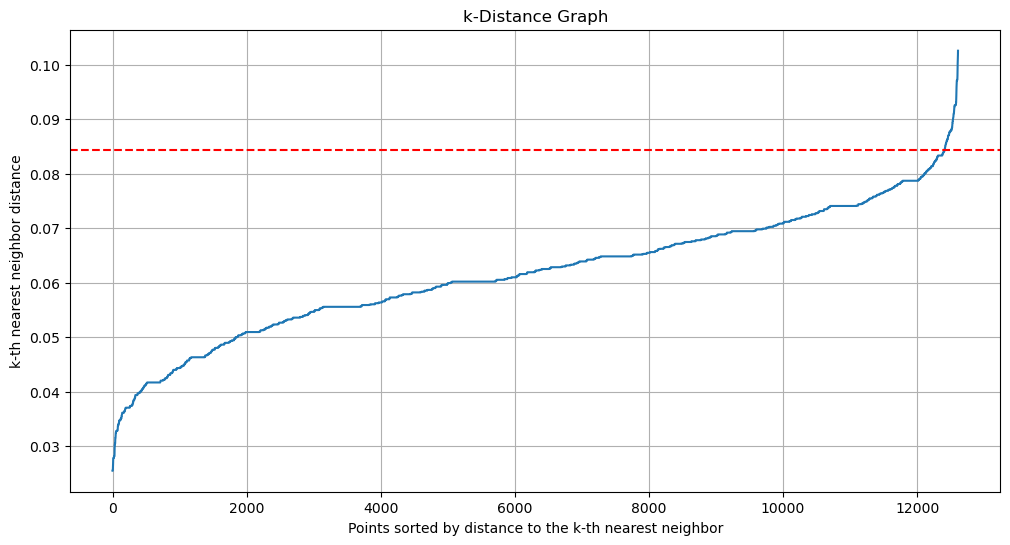

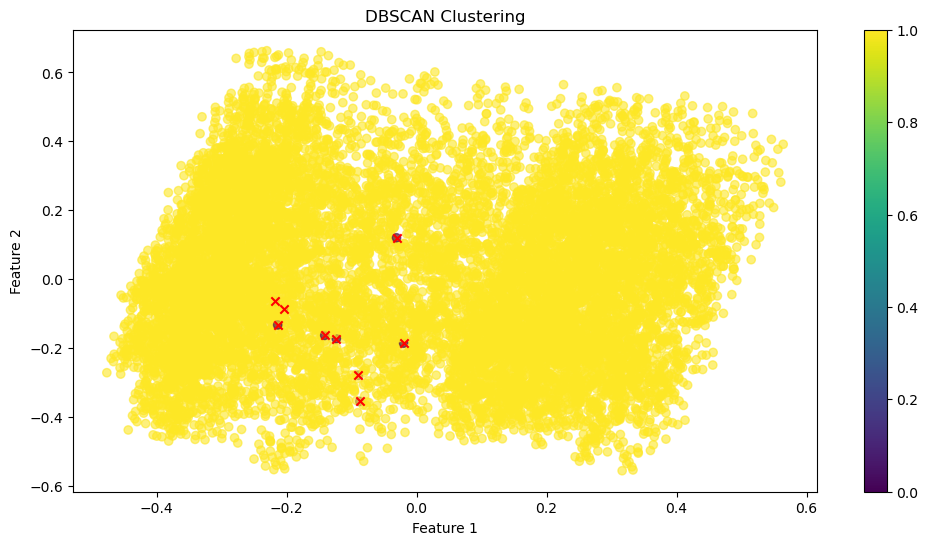



Purity Score: 0.5679619349722442
F-Measure: 0.8041432061531079
Percentage of outliers: 0.07137192704203013%, i.e. 9 out of 12610
Clusters' sizes: [    9 12601]


In [27]:
# Step 1: k-Distance Plot to Determine Optimal 'eps'
k = 10 # same as min_samples. 10
neigh = NearestNeighbors(n_neighbors=k, metric='precomputed')
neigh.fit(gower_matrix)
distances, indices = neigh.kneighbors(gower_matrix)
sorted_distances = np.sort(distances, axis=0)[:, k-1]

plot_sorted_distances(sorted_distances)

#### eps heuristic
mean_distance = sorted_distances.mean()
std_distance = sorted_distances.std()
eps_heuristic = mean_distance + 2 * std_distance

# Manually choose an 'eps' value based on the elbow in the k-distance plot, or use the heuristic
eps_value = eps_heuristic
#eps_value = 0.07

# Step 2: Apply DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=k, metric='precomputed')
clusters = dbscan.fit_predict(gower_matrix)

# Step 3: Enhanced Visualization
X_used = X_mca
with_noise_Q = True
plot_results(X_used, clusters, with_noise_Q)

# Step 4: Post-Clustering Analysis
print_results(clusters)

#### Trying with $X_{mca}$

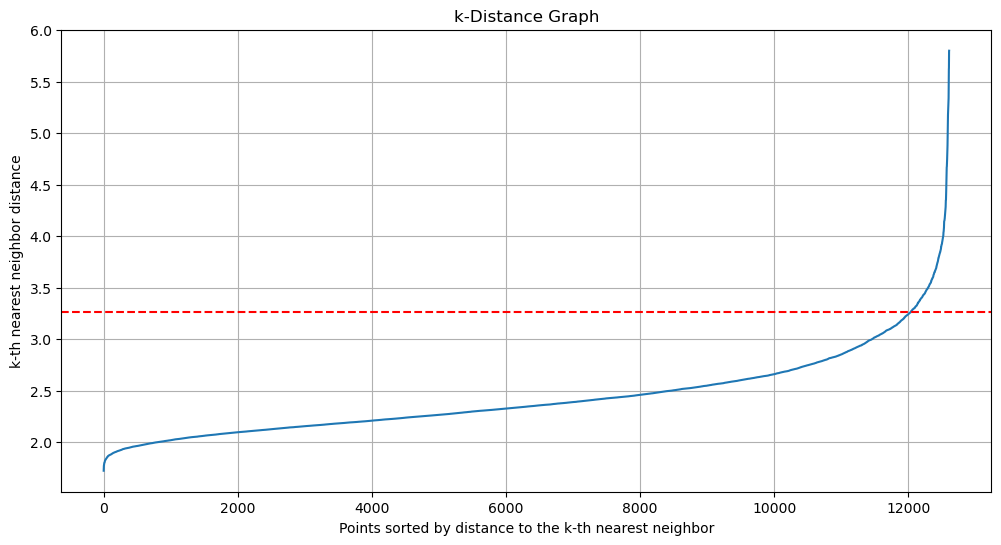

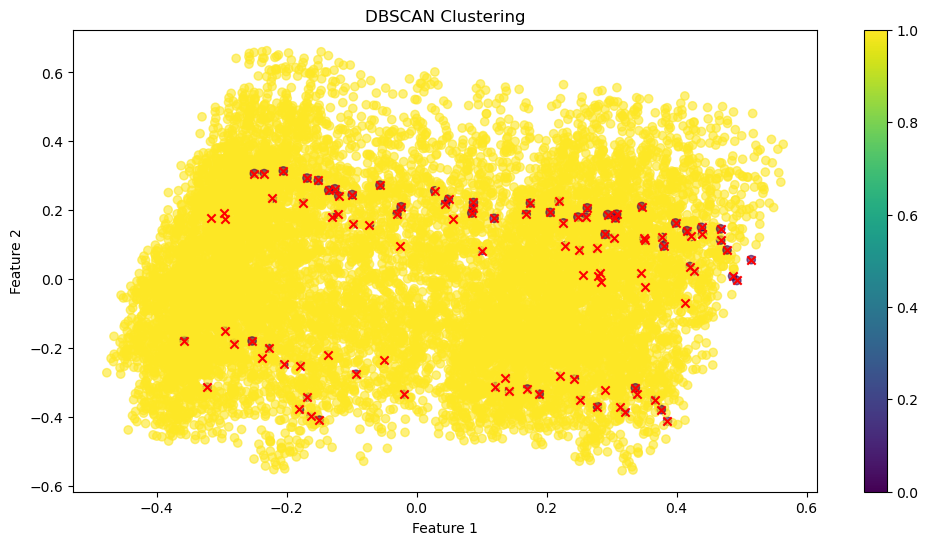



Purity Score: 0.5675654242664552
F-Measure: 0.7020552279778306
Percentage of outliers: 0.8406026962727994%, i.e. 106 out of 12610
Clusters' sizes: [  106 12504]


<Figure size 1200x600 with 0 Axes>

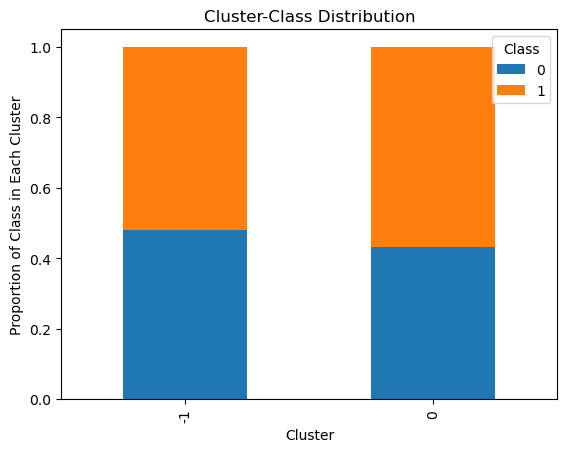

In [97]:
# performing the clustering on the MCA-transformed data instead
# first, the k-distance plot
X_used = X_mca
k = 100 # minPts, should be min n_features + 1, usually 2 * n_features
distance_metric = 'manhattan' # euclidean, manhattan
eps_heuristicQ = True
eps_value = get_k_dist_plot(X_used, gower_matrix, k, distance_metric, eps_heuristicQ)
#eps_value = 8
# second, the DBSCAN clustering
clusters = get_DBSCAN(X_used, X_mca, gower_matrix, k, eps_value, distance_metric, with_noise_Q=True, plotsQ=True, resultsQ=True, clustersQ=True)
# third, printing the results
#print_results(clusters)
# fourth, analyzing the class split on each cluster
plot_cluster_class_distribution(clusters, y, points_for_show=100, var_heightQ=False)

#### Trying with $X_{pca}$

In [83]:
# searching for k values that lead to at least two clusters with more than 400 points
X_used = X_pca
distance_metric = 'euclidean' # euclidean, manhattan
# loop
k_min = 11   
k_max = 100
how_many_found = 0
for k in range(k_min, k_max):
    eps_value = get_k_dist_plot(X_used, gower_matrix, k, distance_metric, eps_heuristicQ=True, plotQ=False)
    clusters = get_DBSCAN(X_used, X_mca, gower_matrix, k, eps_value, distance_metric, with_noise_Q=False, plotsQ=False, resultsQ=False, clustersQ=True)
    # checking whether there are at least two clusters with more than 400 points
    if np.count_nonzero(np.unique(clusters, return_counts=True)[1] >= 400) >= 2:
        print(f"Found k={k} with at least two clusters with more than 400 points")
        how_many_found += 1
        #break
# if no k is found, print a message
if how_many_found == 0:
    print(f"No k found between {k_min} and {k_max} with at least two clusters with more than 400 points")

No k found between 11 and 100 with at least two clusters with more than 400 points


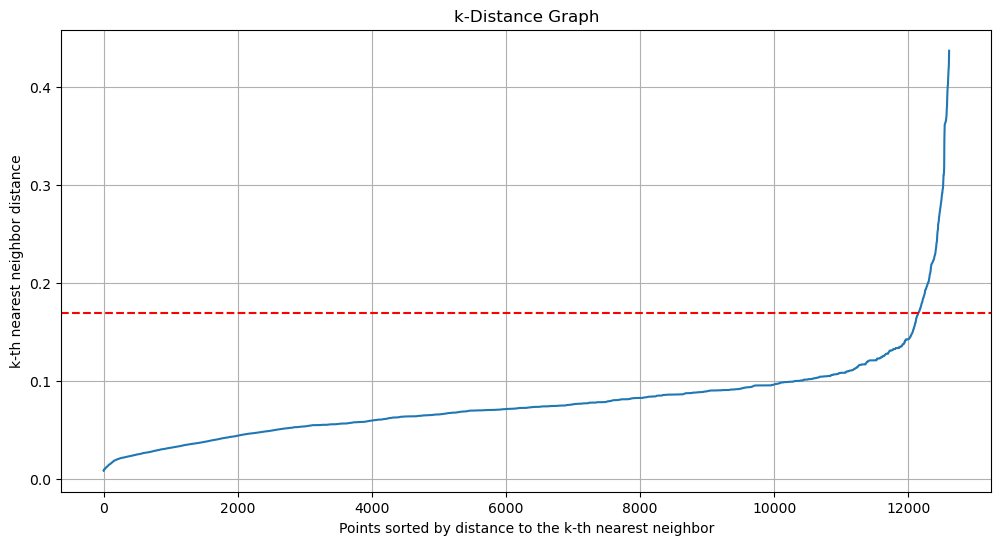

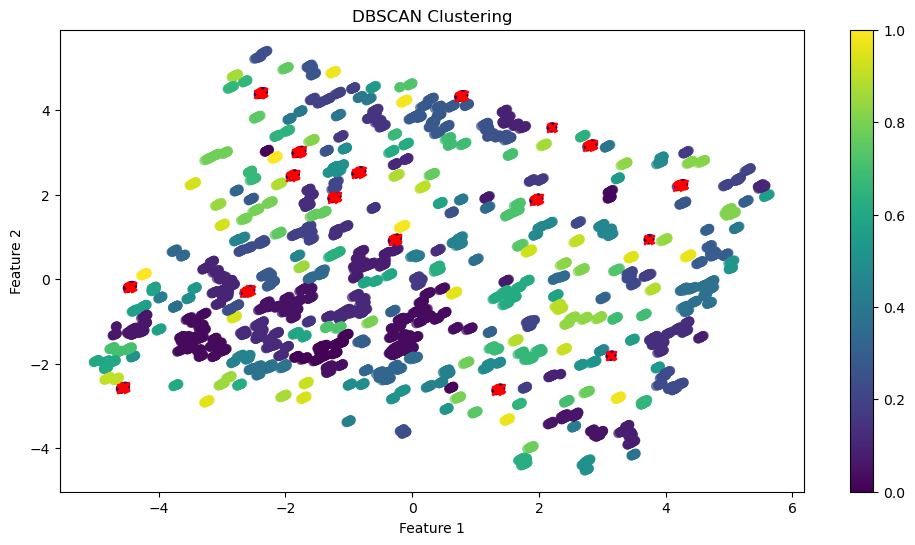



Purity Score: 0.6118160190325139
F-Measure: 0.08892998675342152
Percentage of outliers: 2.386994448850119%, i.e. 301 out of 12610
Clusters' sizes: [301 239  22  22  42 516 610  44 132 302  87 109 209  22  22  22 269 130
 131  49 308  44  44 261 303 109 358  22  66  22 110  22  22  43  22  66
  22  44 110 108  88  65  44  22  66 153  87  43  44  64 136  22  66  22
  51 308  22 109 130  44  22  22  22  22  22  22 175  44  83  22  44  44
  22  43 256  22 175  22  22  44  45  22  22  22  44  22  22  87  66  87
  22  44 122  22  65  44  59  43  22  22  65  86  22  44  36  44  22  22
  22  22  22  22  22  44  22  22  42  22  43  62 109  22 153  44  22  64
  44  44  22  39  22  64  43 130  43  22  44  22  63  22  22  87  34  66
  43  27  22  22  22  22  22  22  22  44  22  22  22  66  73  22  22  22
  87  22  44  22  22  88  22  22  44  22  22  22  22  23  22  22  22  44
  22  44  22  22  22  34  22  22  22  22  22  22  22  22  22  22  22  22
  22  22  22]


<Figure size 1200x600 with 0 Axes>

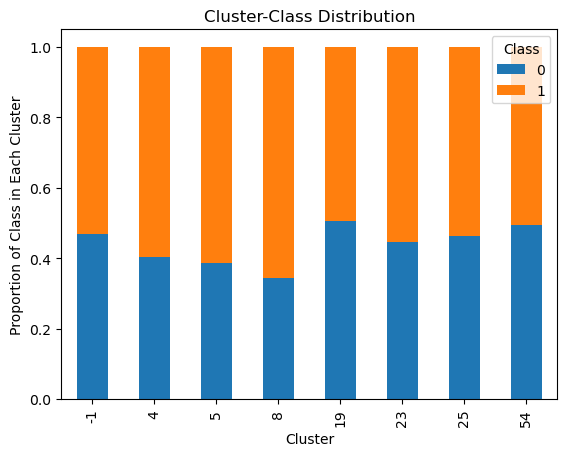

In [53]:
# performing the clustering on the PCA-transformed data instead
# first, the k-distance plot
X_used = X_pca
k = 22
distance_metric = 'euclidean'
eps_heuristicQ = True
eps_value = get_k_dist_plot(X_used, gower_matrix, k, distance_metric, eps_heuristicQ)
#eps_value = 0.3
# second, the DBSCAN clustering
clusters = get_DBSCAN(X_used, X_pca, gower_matrix, k, eps_value, distance_metric, with_noise_Q=True, plotsQ=True, resultsQ=True, clustersQ=True)
# third, printing the results
#print_results(clusters)
# fourth, analyzing the class split on each cluster
plot_cluster_class_distribution(clusters, y, points_for_show=300, var_heightQ=False)

#### Mahalanobis

In [65]:
# Calculate the covariance matrix
cov = np.cov(X, rowvar=False)

# Calculate the inverse of the covariance matrix
inv_cov = np.linalg.inv(cov)

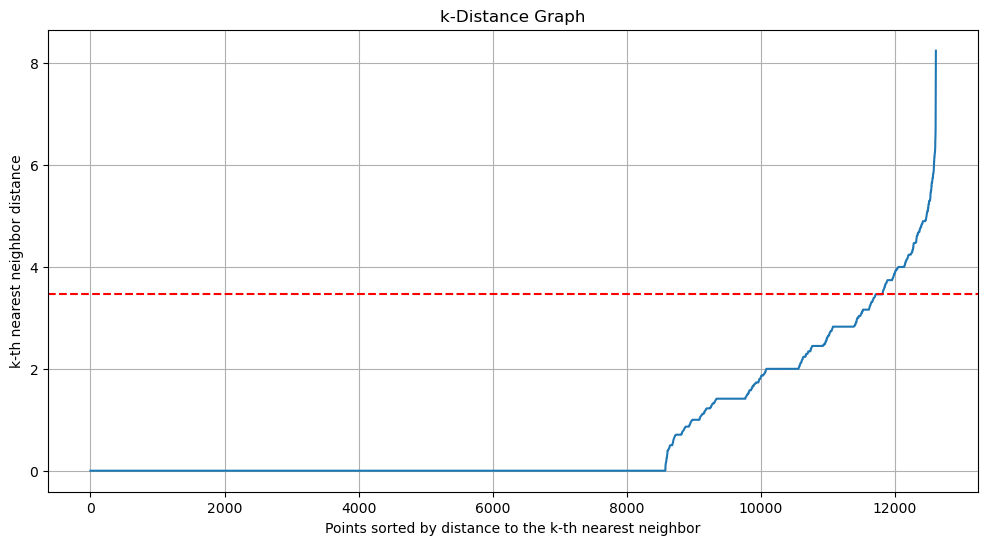

In [66]:
k = 5
# Initialize NearestNeighbors with Mahalanobis metric
neigh = NearestNeighbors(n_neighbors=k, metric='mahalanobis', metric_params={'VI': inv_cov})
neigh.fit(X)

# Calculate distances and indices
distances, indices = neigh.kneighbors(X)

# Sort k-distances and plot
sorted_distances = np.sort(distances, axis=0)[:, k-1]
plot_sorted_distances(sorted_distances)

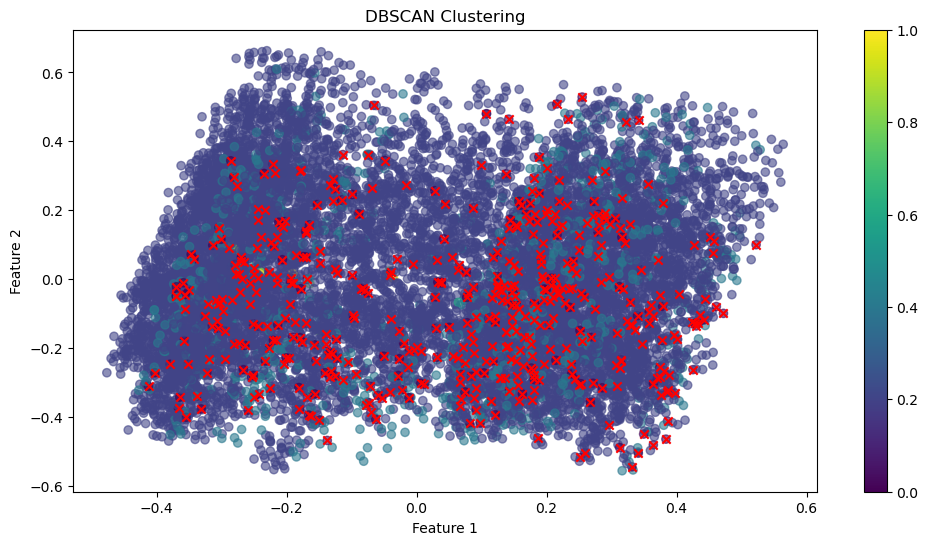



Purity Score: 0.5823949246629659
F-Measure: 0.7116077611943188
Percentage of outliers: 3.7351308485329104%, i.e. 471 out of 12610
Clusters' sizes: [  471 10892  1229     5     7     6]


In [68]:
# *mahalanobis* distance metric
# Applying DBSCAN
dbscan = DBSCAN(eps=3, min_samples=k, metric='mahalanobis', metric_params={'VI': inv_cov})
clusters = dbscan.fit_predict(X)

X_used = X_mca
plot_results(X_used, clusters, with_noise_Q)

# Post-Clustering Analysis
print_results(clusters)

#### sparsity

In [20]:
# sparsity of X
# converting X to a NumPy array for calculation
if isinstance(X, pd.DataFrame):
    X_array = X.to_numpy()
else:
    X_array = X
total_elements = X_array.size # calculating the total number of elements
zero_elements = np.count_nonzero(X_array == 0) # counting the number of zero elements
sparsity_percentage = (zero_elements / total_elements) * 100 # calculating the sparsity percentage
print(f"Sparsity of the X dataset: {sparsity_percentage:.2f}%") # printing result

# sparsity of X_mca
# converting X_mca to a NumPy array for calculation
if isinstance(X_mca, pd.DataFrame):
    X_mca_array = X_mca.to_numpy()
else:
    X_mca_array = X_mca
total_elements = X_mca_array.size # calculating the total number of elements
zero_elements = np.count_nonzero(X_mca_array == 0) # counting the number of zero elements
sparsity_percentage = (zero_elements / total_elements) * 100 # calculating the sparsity percentage
print(f"Sparsity of the X_mca dataset: {sparsity_percentage:.2f}%") # printing result

Sparsity of the X dataset: 70.77%
Sparsity of the X_mca dataset: 0.00%


#### results regarding class splitting

<Figure size 1200x600 with 0 Axes>

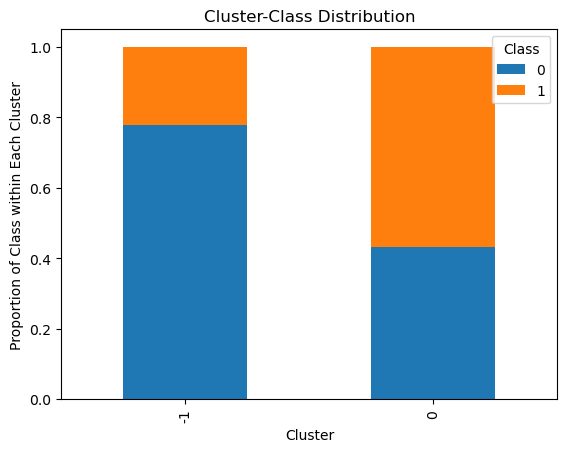

In [28]:
# Assuming 'y' is your response variable and it contains class labels
class_labels = np.unique(y)  # Get unique class labels (e.g., [0, 1] for binary classes)
plot_cluster_class_distribution(clusters, y)

#### post processing (many to 2/3 clusters)

New Purity Score: 0.5675654242664552
New F-Measure: 0.6643920696331587



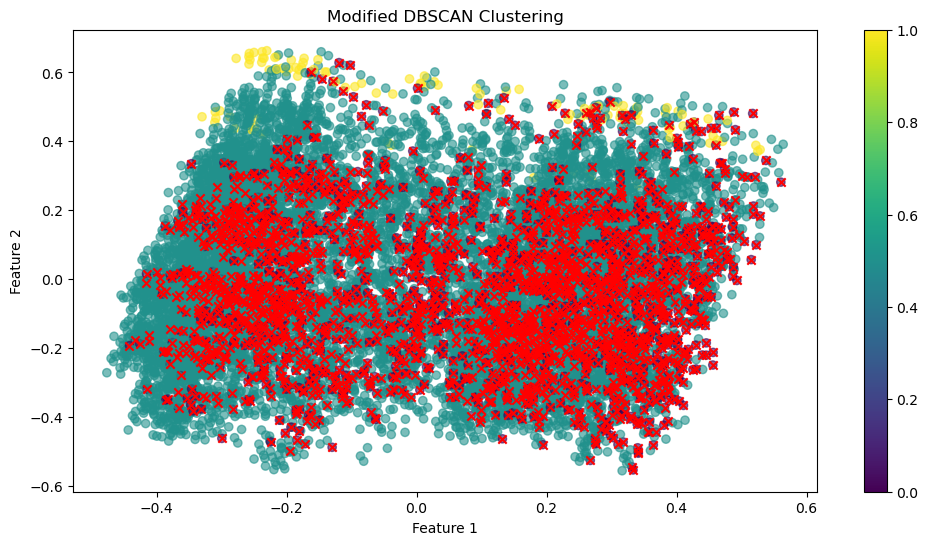

In [115]:
# Post-processing DBSCAN clusters to merge into two groups

unique_clusters = np.unique(clusters[clusters != -1]) # Excluding noise points

# If there are more than two clusters (excluding noise), we'll merge them
if len(unique_clusters) > 2:
    # Calculate the size of each cluster
    cluster_sizes = {cluster: np.sum(clusters == cluster) for cluster in unique_clusters}

    # Sort clusters by size
    sorted_clusters = sorted(cluster_sizes, key=cluster_sizes.get, reverse=True)

    # Merge smaller clusters into the two largest clusters
    largest_clusters = sorted_clusters[:2]
    for i in range(len(clusters)):
        if clusters[i] not in largest_clusters and clusters[i] != -1:
            # Assign to the nearest of the two largest clusters
            # This requires calculating distances to the cluster centroids
            distances_to_largest_clusters = [np.linalg.norm(X.iloc[i] - np.mean(X[clusters == lc], axis=0)) for lc in largest_clusters]
            clusters[i] = largest_clusters[np.argmin(distances_to_largest_clusters)]

# Recalculate purity score and f-measure after merging
new_purity_score = purity_score(y, clusters)
new_f_measure = f_measure(y, clusters)

print(f"New Purity Score: {new_purity_score}")
print(f"New F-Measure: {new_f_measure}\n")

# Plotting the modified clusters
plt.figure(figsize=(12, 6))
plt.scatter(X_used.iloc[:, 0], X_used.iloc[:, 1], c=clusters, cmap='viridis', alpha=0.6, marker='o')
plt.scatter(X_used.iloc[clusters == -1, 0], X_used.iloc[clusters == -1, 1], c='red', alpha=1, marker='x')
plt.title("Modified DBSCAN Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.show()



In [116]:
# printing the number of clusters, plotting their length, purity score, f-measure
unique_clusters, counts_clusters = np.unique(clusters, return_counts=True)
print("Cluster labels and their sizes: ", dict(zip(unique_clusters, counts_clusters)))
print(f"Purity Score: {purity_score(y, clusters)}")
print(f"F-Measure: {f_measure(y, clusters)}\n")


Cluster labels and their sizes:  {-1: 2352, 0: 10149, 1: 109}
Purity Score: 0.5675654242664552
F-Measure: 0.6643920696331587



In [ ]:
# instead of a 2D plot, let's do a 3D "scatterplot", which will be the 

### Spectral clustering

In [ ]:
# Spectral Clustering
spectral = SpectralClustering(n_clusters=3, assign_labels='discretize', random_state=0)
clusters = spectral.fit_predict(X)

# Plotting
plt.scatter(X_mca[:, 0], X_mca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title("Spectral Clustering after PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()